In [ ]:
from google.colab import drive #connecting google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:

!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: cannot open directory '.': No such file or directory


In [ ]:
%cd "/content/drive/MyDrive/Dataset/Final DataSet/Dataset"

/content/drive/MyDrive/Dataset/Final DataSet/Dataset


In [ ]:
%pwd

'/content/drive/MyDrive/Dataset/Final DataSet/Dataset'

In [ ]:
!ls

test  train  val


In [ ]:
!pip install tensorflow

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
# --- 1. Configuration ----------------------------------------------------------
BASE_DIR   = "/content/drive/MyDrive/Dataset/Final DataSet/Dataset"      # contains subfolders train/, val/, test/
IMG_SIZE   = (224, 224)
BATCH_SIZE = 50
EPOCHS     = 50
SEED       = 42

In [ ]:
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

In [ ]:
# --- 2. Load datasets ----------------------------------------------------------
train_ds = image_dataset_from_directory(
    train_dir, label_mode='int', image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,shuffle=True,seed=SEED
)
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8960 files belonging to 4 classes.
Found 1120 files belonging to 4 classes.
Found 1120 files belonging to 4 classes.


['Down', 'Left', 'Right', 'Straight']


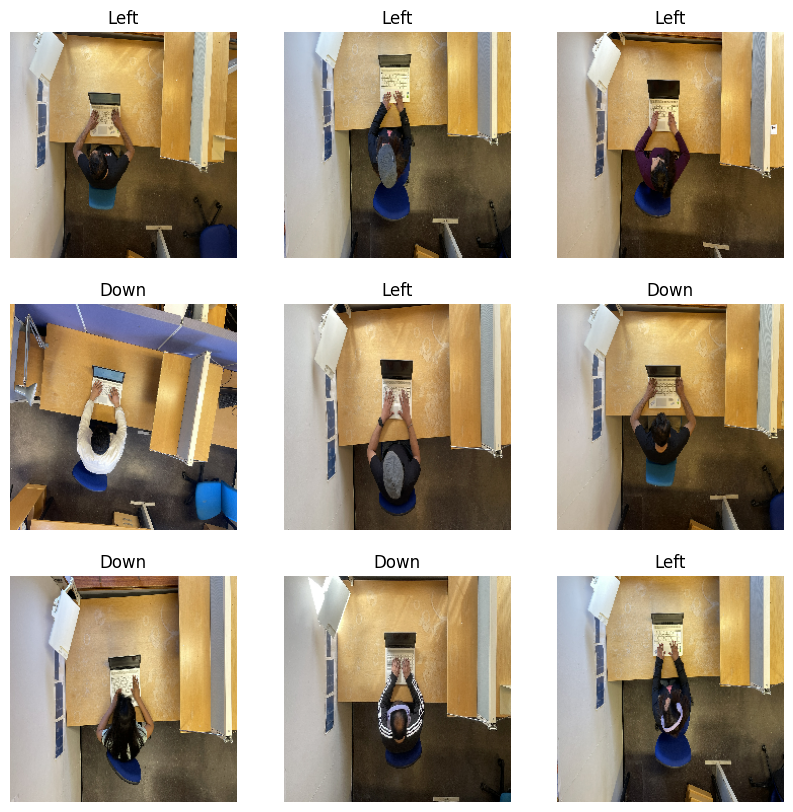

In [ ]:

class_names = train_ds.class_names
print(class_names)

    # plot 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

['Down', 'Left', 'Right', 'Straight']


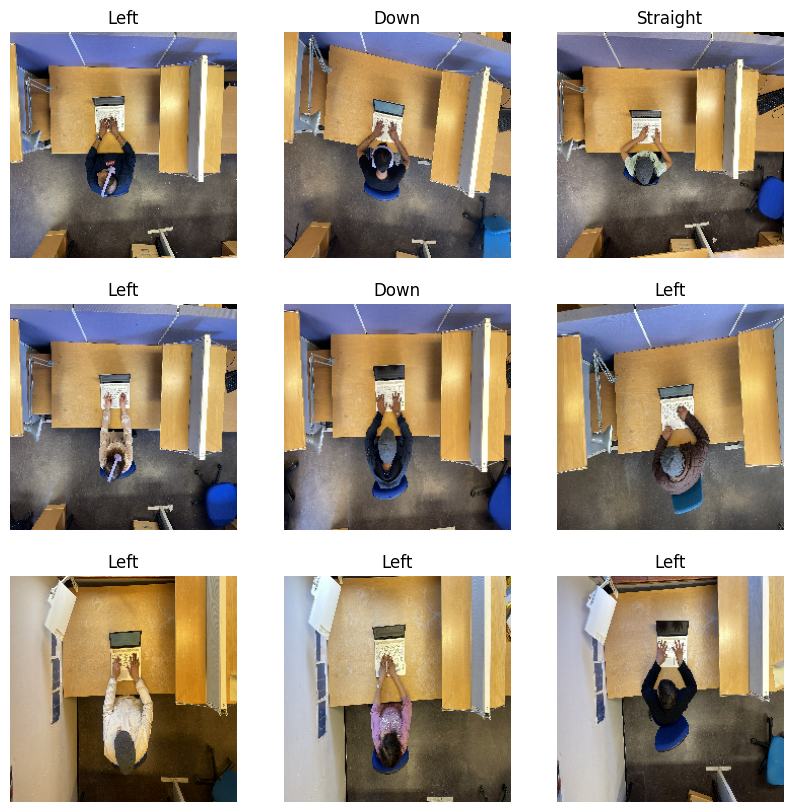

In [ ]:

class_names = test_ds.class_names
print(class_names)

    # plot 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
classes_name=train_ds.class_names
print(class_names)

['Down', 'Left', 'Right', 'Straight']


In [ ]:
# --- 3. Preprocessing ----------------------------------------------------------
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1) Unfreeze the backbone then freeze all but the last 20 layers
base_model = MobileNetV2(input_shape=IMG_SIZE+(3,),
                         include_top=False,
                         weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 2) Recompile with a lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3) Fine-tune for N epochs (fresh count)
fine_tune_epochs = 5

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
        )
    ]
)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 92s 449ms/step - accuracy: 0.6560 - loss: 0.8424 - val_accuracy: 0.6848 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 426ms/step - accuracy: 0.6496 - loss: 0.8400 - val_accuracy: 0.6964 - val_loss: 0.7632 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 423ms/step - accuracy: 0.6594 - loss: 0.8250 - val_accuracy: 0.6839 - val_loss: 0.7997 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6477 - loss: 0.8394
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 426ms/step - accuracy: 0.6476 - loss: 0.8395 - val_accuracy: 0.6821 - val_loss: 0.7800 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 423ms/step - accuracy: 0.6469 - loss: 0.8408 - val_accuracy: 0.6857 - val_loss: 0.7627 - learning_rate: 5.0000e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 78s 432ms/step - accuracy: 0

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- 7. Confusion Matrix & Classification Report ------------------------------

# 7.1 Gather true labels and predicted labels from test_ds
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# If your test_ds batches are “(images, labels)”, get predictions as class indices:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 7.2 Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 7.3 Compute overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.3f}")

# 7.4 Detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true,
                            y_pred,
                            target_names=classes_name,
                            digits=3))

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 530ms/step
Confusion Matrix:
[[226  14   9  31]
 [ 19 156  60  45]
 [ 17  62 164  37]
 [ 35  26  31 188]]

Accuracy: 0.655

Classification Report:
              precision    recall  f1-score   support

        Down      0.761     0.807     0.783       280
        Left      0.605     0.557     0.580       280
       Right      0.621     0.586     0.603       280
    Straight      0.625     0.671     0.647       280

    accuracy                          0.655      1120
   macro avg      0.653     0.655     0.653      1120
weighted avg      0.653     0.655     0.653      1120



In [ ]:
# 1. Save your Keras model in HDF5 (or SavedModel) format
model.save("mobilenet_v2.h5")  # ~14–15 MB on disk


In [ ]:
import tensorflow as tf

# … after training your `model` …
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Quantize to int8 for ~2 MB size:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def repr_data_gen():
    for images, _ in train_ds.take(100):
        yield [tf.cast(images, tf.float32)]
converter.representative_dataset = repr_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
with open("model_int8.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt28j_aon'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_471')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137724371798160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020580624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020583696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137724371798928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137724371804880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020581200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020584080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020578896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020581776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722020583312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1377220205

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step


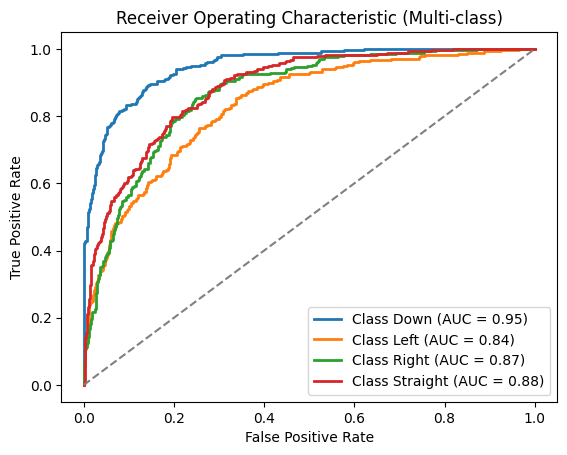

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Gather true labels and predicted probabilities
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_score = model.predict(test_ds)   # shape (n_samples, n_classes)

# 2a. If binary classification (n_classes == 2):
if y_score.shape[1] == 2:
    # take probability for the positive class (index 1)
    y_prob_pos = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary)')
    plt.legend(loc='lower right')
    plt.show()

# 2b. If multi-class classification:
else:
    n_classes = y_score.shape[1]
    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 lw=2, label=f'Class {classes_name[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Multi-class)')
    plt.legend(loc='lower right')
    plt.show()

# Augmented Model: Trained on the same images but with added variations:
Rotation: Images randomly tilted up to 15 degrees left/right.
Brightness: Images made slightly darker or brighter (up to 20% change). No horizontal and
vertical flipping because it change the left and right images.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dropout, Dense, Lambda, RandomRotation
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
BASE_DIR   = "/content/drive/MyDrive/Dataset/Final DataSet/Dataset"      # contains train/, val/, test/
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 50
SEED       = 42

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

In [ ]:
# --- 2. Load datasets ----------------------------------------------------------
train_ds = image_dataset_from_directory(
    train_dir, label_mode='int', image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_ds = image_dataset_from_directory(
    val_dir, label_mode='int', image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, shuffle=False
)
test_ds = image_dataset_from_directory(
    test_dir, label_mode='int', image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, shuffle=False
)

Found 8960 files belonging to 4 classes.
Found 1120 files belonging to 4 classes.
Found 1120 files belonging to 4 classes.


In [ ]:
# --- 3. Preprocessing & Augmentation ------------------------------------------
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Define augmentation pipeline using the public API
data_augmentation = tf.keras.Sequential([
    # Random rotation up to ±15°
    RandomRotation(factor=15/360.0),
    # Random brightness up to ±20%
    Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2))
], name="augmentation")

def prep_and_augment(images, labels, training=False):
    images = preprocess_input(images)
    if training:
        images = data_augmentation(images)
    return images, labels


In [ ]:
# Apply to datasets
train_ds = train_ds.map(lambda x, y: prep_and_augment(x, y, training=True)) \
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: prep_and_augment(x, y, training=False)) \
                 .prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: prep_and_augment(x, y, training=False)) \
                  .prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1) Unfreeze the backbone then freeze all but the last 20 layers
base_model = MobileNetV2(input_shape=IMG_SIZE+(3,),
                         include_top=False,
                         weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 2) Recompile with a lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3) Fine-tune for N epochs (fresh count)
fine_tune_epochs = 5

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
        )
    ]
)



Epoch 1/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 114s 377ms/step - accuracy: 0.4735 - loss: 1.3568 - val_accuracy: 0.6375 - val_loss: 0.8811 - learning_rate: 0.0010
Epoch 2/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - accuracy: 0.4894 - loss: 1.3051 - val_accuracy: 0.6366 - val_loss: 0.8676 - learning_rate: 0.0010
Epoch 3/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - accuracy: 0.5062 - loss: 1.2399 - val_accuracy: 0.6134 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 4/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5048 - loss: 1.2353
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.5048 - loss: 1.2352 - val_accuracy: 0.6205 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 5/5
280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 293ms/step - accuracy: 0.5141 - loss: 1.1794 - val_accuracy: 0.6036 - val_loss: 0.9422 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# --- 6. Evaluate --------------------------------------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test   Loss: {test_loss:.3f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5826 - loss: 1.0545
Test Accuracy: 0.543
Test   Loss: 1.164


In [ ]:
# --- 7. Confusion Matrix & Classification Report ------------------------------
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred       = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred,
                            target_names=classes_name,
                            digits=3))


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step

Confusion Matrix:
 [[265   0   9   6]
 [  5 197  63  15]
 [  3  15 250  12]
 [ 11   3  33 233]]

Accuracy: 0.84375

Classification Report:
               precision    recall  f1-score   support

        Down      0.933     0.946     0.940       280
        Left      0.916     0.704     0.796       280
       Right      0.704     0.893     0.787       280
    Straight      0.876     0.832     0.853       280

    accuracy                          0.844      1120
   macro avg      0.857     0.844     0.844      1120
weighted avg      0.857     0.844     0.844      1120



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Gather true labels and predicted probabilities
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_score = model.predict(test_ds)   # shape (n_samples, n_classes)

# 2a. If binary classification (n_classes == 2):
if y_score.shape[1] == 2:
    # take probability for the positive class (index 1)
    y_prob_pos = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary)')
    plt.legend(loc='lower right')
    plt.show()

# 2b. If multi-class classification:
else:
    n_classes = y_score.shape[1]
    # binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 lw=2, label=f'Class {classes_name[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Augmented Receiver Operating Characteristic (Multi-class)')
    plt.legend(loc='lower right')
    plt.show()

NameError: name 'test_ds' is not defined

In [ ]:
img_path   = "/content/drive/MyDrive/Dataset/Final DataSet/Dataset/test/Down/Down_non_occluded_00001023.jpg"
IMG_SIZE   = (224, 224)

# 3. Load & preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)      # PIL image
x   = image.img_to_array(img)                             # to numpy array
x   = np.expand_dims(x, axis=0)                           # add batch dim
x   = preprocess_input(x)                                 # scale pixels

# 4. Predict
preds      = model.predict(x)                             # shape (1, n_classes)
pred_idx   = np.argmax(preds[0])                          # index of highest score
confidence = preds[0][pred_idx] * 100                     # percentage

# 5. Map index back to class label
#    This assumes you still have `train_ds` in scope:
class_names = train_ds.class_names                        # e.g. ['cat','dog',...]
pred_label  = class_names[pred_idx]

print(f"Predicted class : {pred_label}")
print(f"Confidence      : {confidence:.1f}%")

NameError: name 'image' is not defined